In [1]:
!pip install -q -U albumentations

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
data, info= tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)
data

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to C:\Users\user\tensorflow_datasets\tf_flowers\3.0.0. Subsequent calls will reuse this data.


<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [14]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [16]:
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

C:\Users\user\miniconda3\envs\deep_tf\lib\site-packages\albumentations\augmentations\transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
C:\Users\user\miniconda3\envs\deep_tf\lib\site-packages\albumentations\augmentations\transforms.py:780: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  FutureWarning,
C:\Users\user\miniconda3\envs\deep_tf\lib\site-packages\albumentations\augmentations\transforms.py:1641: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [17]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [18]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [19]:
# create dataset
ds_alb = data.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset shapes: (<unknown>, ()), types: (tf.float32, tf.int64)>

In [22]:
def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

In [23]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset shapes: ((None, 120, 120, 3), (None,)), types: (tf.float32, tf.int64)>

In [28]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(15, 15))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

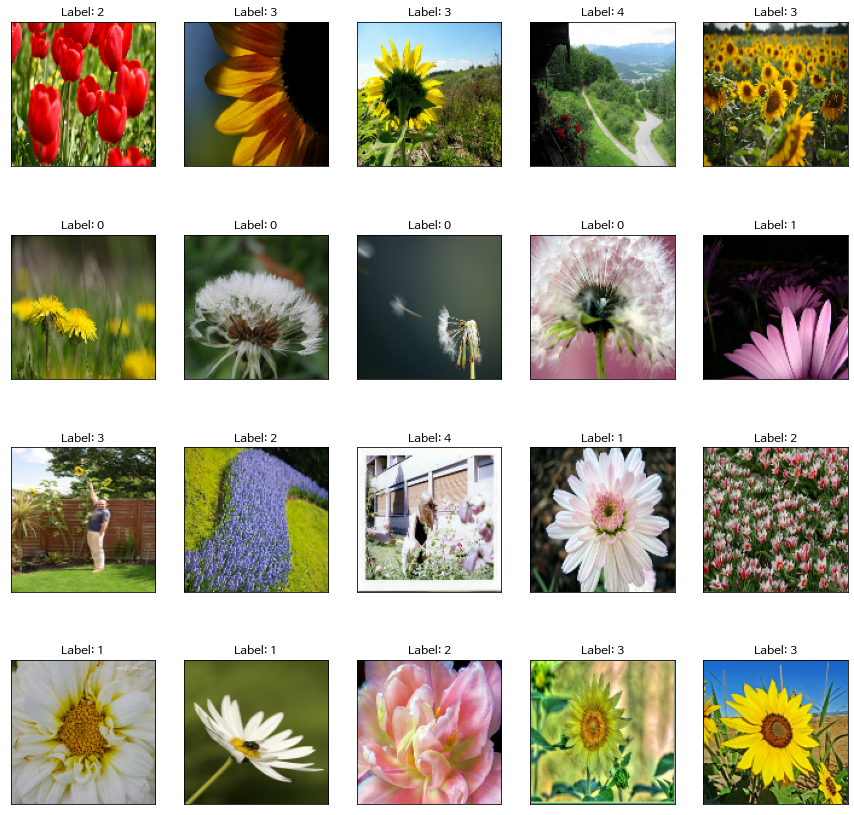

In [29]:
view_image(ds_tf)

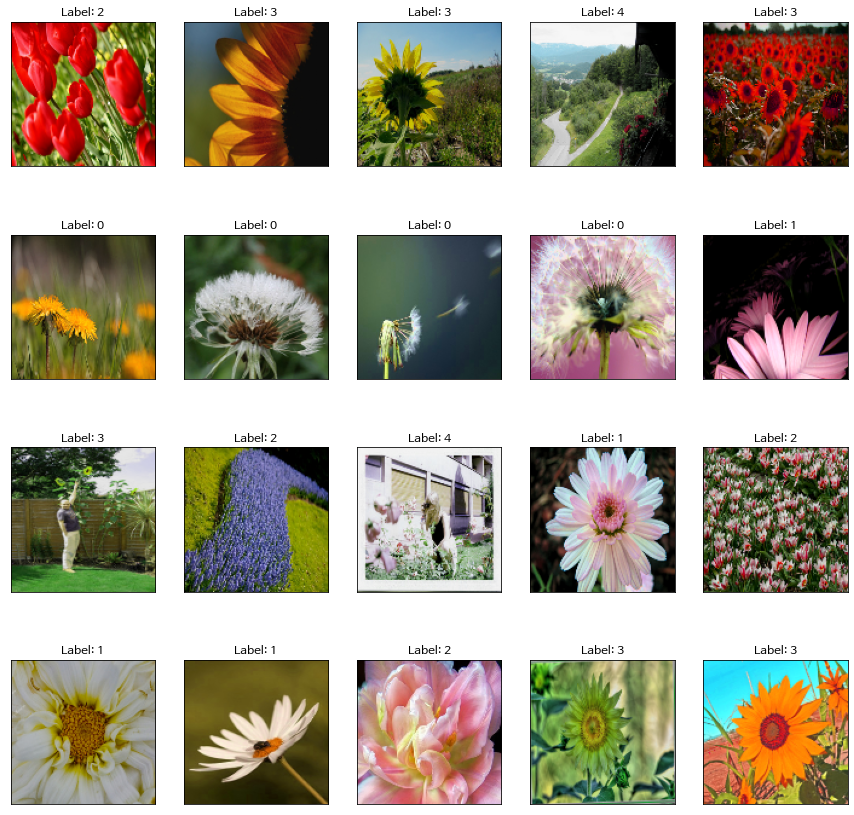

In [30]:
view_image(ds_alb)

In [25]:
import keras

In [26]:
input = keras.Input(shape=(120, 120, 3))
x = keras.layers.Conv2D(32, (3, 3), activation="relu")(input)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=input, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 17s 54ms/step - loss: 1.5145 - accuracy: 0.3156
Epoch 2/2
115/115 [==============================] - 4s 39ms/step - loss: 1.1546 - accuracy: 0.5419
